In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import skimage
import os
import sys
import sqlite3
import shutil
from scipy import stats
from time import time
sys.path.append(os.environ['REPO_DIR'])
from lib.utils import configuration, run
from matplotlib.path import Path
from shapely.geometry import Polygon
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
from skimage import io
from glob import glob
img_dir = '/Users/kuiqian/Downloads/Slide56/'
img_fn = [fn for fn in glob(img_dir+'*')]

In [7]:
img = io.imread(img_fn[0])
img.dtype

dtype('uint16')

In [8]:
%%time
for fn in img_fn:
    img = io.imread(fn)
    img = np.uint8(img/65535*255)
    cv2.imwrite(fn, img)

CPU times: user 227 ms, sys: 40.5 ms, total: 267 ms
Wall time: 307 ms


In [2]:
fn = '/Users/kuiqian/Downloads/MD585_annotation.csv'
annotation = pd.read_csv(fn)

In [3]:
annotation

,Unnamed: 0,class,creator,edits,filename,id,label_position,name,orientation,parent_structure,resolution,section,side,side_manually_assigned,time_created,type,vertices
0,100258793423455,contour,yuncong,"[{'username': 'yuncong', 'timestamp': '0531201...",MD585-N32-2015.08.19-16.07.10_MD585_2_0095,100258793423455,[18711.7365562 6484.99160175],SC,sagittal,[],raw,177,S,False,5312018035327,intersected,[[17792.64970884 8101.83054608]\n [17705.6952...
1,10046548601575,contour,yuncong,"[{'username': 'yuncong', 'timestamp': '0922201...",MD585-N59-2015.07.16-23.44.31_MD585_1_0175,10046548601575,[18968.41599633 9596.73896609],VCP,sagittal,[],raw,341,R,False,9222016045400,intersected,[[18929.31113635 9950.00838242]\n [18794.7410...
2,100533775762985,contour,yuncong,"[{'username': 'yuncong', 'timestamp': '0922201...",MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051,100533775762985,[18106.06001671 12471.8048431 ],VCP,sagittal,[],raw,90,L,True,9222016132929,intersected,[[17809.20007933 12446.57951106]\n [17890.2019...
3,100576744061255,contour,yuncong,"[{'username': 'yuncong', 'timestamp': '0531201...",MD585-N23-2015.07.16-20.51.24_MD585_2_0068,100576744061255,[23867.10454651 13460.67553601],Sp5C,sagittal,[],raw,123,L,False,5312018040248,intersected,[[23840.08041332 14615.0865205 ]\n [23753.3038...
4,100630949855716,contour,yuncong,"[{'username': 'yuncong', 'timestamp': '0922201...",MD585-N38-2015.07.16-22.04.12_MD585_1_0112,100630949855716,[26910.11614311 11658.28584195],10N,sagittal,[],raw,211,R,False,9222016025514,intersected,[[27590.85115166 12229.27937831]\n [27470.8846...
5,100645280892232,contour,yuncong,"[{'username': 'yuncong', 'timestamp': '0922201...",MD585-N35-2015.07.16-21.48.15_MD585_2_0104,100645280892232,[19542.45258556 13549.07081121],Pn,sagittal,[],raw,195,L,False,9222016023054,confirmed,[[18644.74132843 12995.26638841]\n [18747.3370...
6,100686996266331,contour,yuncong,"[{'username': 'yuncong', 'timestamp': '0922201...",MD585-IHC50-2015.07.16-18.02.54_MD585_3_0150,100686996266331,[24211.08219658 11501.30502335],7N,sagittal,[],raw,284,R,False,9222016041734,intersected,[[23964.65895344 11840.12744606]\n [23804.6673...
7,100724107789223,contour,yuncong,"[{'username': 'yuncong', 'timestamp': '0922201...",MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050,100724107789223,[17570.60995595 12211.19329149],DC,sagittal,[],raw,88,L,False,9222016164436,intersected,[[17713.3255817 12406.48223338]\n [17593.8165...
8,100932728261976,contour,yuncong,"[{'username': 'yuncong', 'timestamp': '0521201...",MD585-IHC33-2015.07.16-16.33.07_MD585_2_0098,100932728261976,[19460.23981199 13632.17363432],Pn,sagittal,[],raw,184,L,False,5212018173918,intersected,[[20291.16557673 14254.21891894]\n [20204.2095...
9,101154233788644,contour,yuncong,"[{'username': 'yuncong', 'timestamp': '0922201...",MD585-IHC32-2015.08.19-13.53.29_MD585_2_0095,101154233788644,[20043.89747584 12992.84697876],RtTg,sagittal,[],raw,178,S,False,9222016032138,intersected,[[20084.54222259 13508.4597248 ]\n [19941.1185...


In [13]:
stack = 'MD585'
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}

In [17]:
section = 105
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_thumbnail/'
img_fn = raw_images_root + section_to_filename[section] + '_prep2_thumbnail.tif'
setup_download_from_s3(img_fn, recursive=False)

run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_prep2_thumbnail/MD585-N20-2015.07.16-20.47.19_MD585_2_0059_prep2_thumbnail.tif /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_prep2_thumbnail/MD585-N20-2015.07.16-20.47.19_MD585_2_0059_prep2_thumbnail.tif


In [15]:
section = 181
root = 'CSHL_data_processed/'+stack+'/'+stack+'_elastix_output/'
fn = root + section_to_filename[section+1] +'_to_'+section_to_filename[section]+ '/TransformParameters.0.txt'
setup_download_from_s3(fn, recursive=False)

run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_elastix_output/MD585-IHC33-2015.07.16-16.33.07_MD585_1_0097_to_MD585-N33-2015.07.16-21.37.52_MD585_1_0097/TransformParameters.0.txt /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_elastix_output/MD585-IHC33-2015.07.16-16.33.07_MD585_1_0097_to_MD585-N33-2015.07.16-21.37.52_MD585_1_0097/TransformParameters.0.txt


In [11]:
section

180

In [4]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    return x,y


def setup_download_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(s3_fp, local_fp))
    else:
        run('aws s3 cp {0} {1}'.format(s3_fp, local_fp))

In [3]:
stack = 'DK39'
section = 265
db_dir = 'CSHL_databases/' + stack + '/'
db_fp = db_dir + str(section) + '.db'
setup_download_from_s3(db_fp, recursive=False)
conn = sqlite3.connect(os.environ['ROOT_DIR'] + db_fp)
cur = conn.cursor()

raws = cur.execute('SELECT * FROM features')
info = np.array(list(raws))
locations = info[:, 1:3]
features_all = info[:, 3:]

ALREADY DOWNLOADED FILE


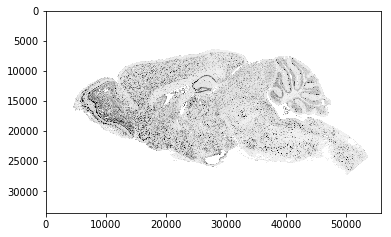

In [4]:
from skimage import io
img_fn = os.path.join(os.environ['ROOT_DIR'], stack, 'aligned', str(section)+'.tif')
img = io.imread(img_fn)
m, n = img.shape
imshow(img, cmap='gray')

In [5]:
up = 18000
down = 25000
left = 38000
right = 50000

raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
info = np.array(list(raws))
locations_part = info[:, 1:3]
features_part = info[:, 3:]

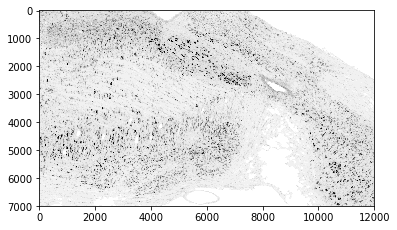

In [6]:
imshow(img[up:down, left:right], cmap='gray')

In [6]:
%%time
locations_all = []
features_all = []
locations_part = []
features_part = []

section = 263
for i in range(5):
    db_dir = 'CSHL_databases/' + stack + '/'
    db_fp = db_dir + str(section+i) + '.db'
    setup_download_from_s3(db_fp, recursive=False)
    conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
    cur = conn.cursor() 
    
    raws = cur.execute('SELECT * FROM features')
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    locations_all.extend(locations)
    features_all.extend(features)
    
    raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    locations_part.extend(locations)
    features_part.extend(features)

features_all = np.array(features_all)
features_part = np.array(features_part)
locations_all = np.array(locations_all)
locations_part = np.array(locations_part)

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
CPU times: user 11.8 s, sys: 956 ms, total: 12.8 s
Wall time: 14.1 s


In [7]:
%%time
locations_all_ten = []
features_all_ten = []
locations_part_ten = []
features_part_ten = []

section = 261
for i in range(10):
    db_dir = 'CSHL_databases/' + stack + '/'
    db_fp = db_dir + str(section+i) + '.db'
    setup_download_from_s3(db_fp, recursive=False)
    conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
    cur = conn.cursor() 
    
    raws = cur.execute('SELECT * FROM features')
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    locations_all_ten.extend(locations)
    features_all_ten.extend(features)
    
    raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    locations_part_ten.extend(locations)
    features_part_ten.extend(features)

features_all_ten = np.array(features_all_ten)
features_part_ten = np.array(features_part_ten)
locations_all_ten = np.array(locations_all_ten)
locations_part_ten = np.array(locations_part_ten)

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
CPU times: user 24.6 s, sys: 1.91 s, total: 26.5 s
Wall time: 30.7 s


In [8]:
%%time
background_ten = []
for i in range(20):
    x1, y1 = CDF(features_all_ten[:,i])
    num = 2000
    x2 = [x1[np.argmin(np.absolute(y1-(j+1)/num))] for j in range(num)]
    x2 = np.array(x2)
    background_ten.append(x2)

CPU times: user 6min, sys: 1min 22s, total: 7min 22s
Wall time: 8min 2s


In [9]:
%%time
background = []
for i in range(20):
    x1, y1 = CDF(features_all[:,i])
    num = 2000
    x2 = [x1[np.argmin(np.absolute(y1-(j+1)/num))] for j in range(num)]
    x2 = np.array(x2)
    background.append(x2)

CPU times: user 2min 45s, sys: 43.5 s, total: 3min 29s
Wall time: 3min 55s


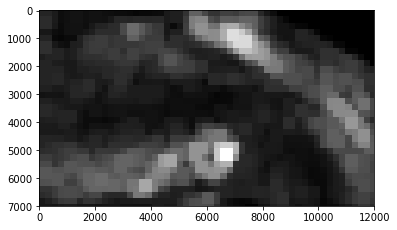

CPU times: user 17.9 s, sys: 1.13 s, total: 19.1 s
Wall time: 25.8 s


In [11]:
%%time
stride = 224
window_size = 448
xs, ys = np.meshgrid(np.arange(left, right, stride), np.arange(up, down, stride), indexing='xy')
# xs, ys = np.meshgrid(np.arange(0, n, stride), np.arange(0, m, stride), indexing='xy')
windows = np.c_[xs.flat, ys.flat]
# p_values = np.zeros((len(windows), 20))

hsv_ten = np.zeros([m, n],dtype='float32')
for index in range(len(windows)):
    wx = int(windows[index][0])
    wy = int(windows[index][1])
    indices_window = np.where((locations_part_ten[:, 0] > wx) & (locations_part_ten[:, 0] < wx + window_size) \
                              & (locations_part_ten[:, 1] > wy) & (locations_part_ten[:, 1] < wy + window_size))[0]
    if len(indices_window):
        cells = features_part_ten[indices_window]
        eva = 0
        p_value = []
        for i in range(20):
            x1 = background_ten[i]
            x2, y2 = CDF(cells[:,i])
            value = stats.ks_2samp(x1, x2)[1]
            eva += - np.log(value)
            p_value.append(- np.log(value))
#         eva = max(p_value)
        eva = sum(sorted(p_value, reverse=True)[:5])
#         p_values[index] = np.array(p_value)
#         p_values.append(p_value)
        origin = hsv_ten[wy: wy + window_size, wx: wx + window_size]
        satua_img = np.zeros_like(origin) + eva
        comp = np.absolute(origin) - np.absolute(satua_img)
        hsv_ten[wy: wy + window_size, wx: wx + window_size] = origin * (comp >= 0) + satua_img * (comp < 0) 
plt.figure()
ks_map_ten = hsv_ten[up:down, left:right].copy()

# com = cv2.polylines(ks_map, cs, True, [0, 255, 0], 50, lineType=8)
plt.imshow(ks_map_ten, cmap='gray')
# plt.title(structure)
plt.show()

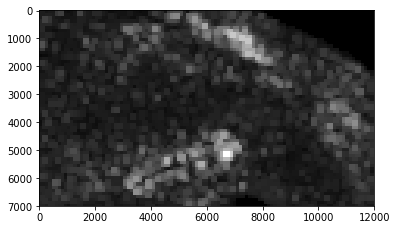

CPU times: user 42.1 s, sys: 1.24 s, total: 43.3 s
Wall time: 51 s


In [10]:
%%time
stride = 112
window_size = 224
xs, ys = np.meshgrid(np.arange(left, right, stride), np.arange(up, down, stride), indexing='xy')
# xs, ys = np.meshgrid(np.arange(0, n, stride), np.arange(0, m, stride), indexing='xy')
windows = np.c_[xs.flat, ys.flat]
# p_values = np.zeros((len(windows), 20))

hsv = np.zeros([m, n],dtype='float32')
for index in range(len(windows)):
    wx = int(windows[index][0])
    wy = int(windows[index][1])
    indices_window = np.where((locations_part[:, 0] > wx) & (locations_part[:, 0] < wx + window_size) \
                              & (locations_part[:, 1] > wy) & (locations_part[:, 1] < wy + window_size))[0]
    if len(indices_window):
        cells = features_part[indices_window]
        eva = 0
        p_value = []
        for i in range(20):
            x1 = background[i]
            x2, y2 = CDF(cells[:,i])
            value = stats.ks_2samp(x1, x2)[1]
            eva += - np.log(value)
            p_value.append(- np.log(value))
#         eva = max(p_value)
        eva = sum(sorted(p_value, reverse=True)[:5])
#         p_values[index] = np.array(p_value)
#         p_values.append(p_value)
        origin = hsv[wy: wy + window_size, wx: wx + window_size]
        satua_img = np.zeros_like(origin) + eva
        comp = np.absolute(origin) - np.absolute(satua_img)
        hsv[wy: wy + window_size, wx: wx + window_size] = origin * (comp >= 0) + satua_img * (comp < 0) 
plt.figure()
ks_map = hsv[up:down, left:right].copy()

# com = cv2.polylines(ks_map, cs, True, [0, 255, 0], 50, lineType=8)
plt.imshow(ks_map, cmap='gray')
# plt.title(structure)
plt.show()

In [ ]:
%%time
# trial = np.zeros([m, n],dtype='float32')
mask_ten = hsv_ten.copy()
stride = 224
window_size = 448
# loc = []
for seq in range(3000):
    threshold = mask_ten[trial==0].max()

    index_max = np.where(mask_ten==threshold)
    xmin = index_max[1].min()
    ymin = index_max[0].min()
    xmax = index_max[1].max()
    ymax = index_max[0].max()
    
    if xmax-xmin<window_size-1 or ymax-ymin<window_size-1:
        mask_ten[mask_ten==threshold] = 0
        continue
    
    wx = xmin
    wy = ymin
    indices_window = np.where((locations_part_ten[:, 0] > wx) & (locations_part_ten[:, 0] < wx + window_size) \
                                  & (locations_part_ten[:, 1] > wy) & (locations_part_ten[:, 1] < wy + window_size))[0]
    cells = features_part_ten[indices_window]
    eva = []
    foreground = []
    for i in range(20):
        x1 = background_ten[i]
        x2, y2 = CDF(cells[:,i])
        value = stats.ks_2samp(x1, x2)[1]
        eva.append(- np.log(value))
        foreground.append(x2)
    eva = sum(sorted(eva, reverse=True)[:5])
    print(threshold, eva, len(loc))
    
    skip = 0
    for wx, wy in loc:
        distance = np.linalg.norm([wx-xmin, wy-ymin])
        if distance < 1000:
            indices_window = np.where((locations_part_ten[:, 0] > wx) & (locations_part_ten[:, 0] < wx + window_size) \
                                      & (locations_part_ten[:, 1] > wy) & (locations_part_ten[:, 1] < wy + window_size))[0]
            if len(indices_window):
                cells = features_part_ten[indices_window]
                eva1 = []
                eva2 = []
                for i in range(20):
                    x1 = background_ten[i]
                    x2, y2 = CDF(cells[:,i])
                    value = stats.ks_2samp(x1, x2)[1]
                    eva1.append(- np.log(value))

                    x3 = foreground[i]
                    value = stats.ks_2samp(x3, x2)[1]
                    eva2.append(- np.log(value))
                eva1 = sum(sorted(eva1, reverse=True)[:5])
                eva2 = sum(sorted(eva2, reverse=True)[:5])
                if eva1 >= alpha*eva2:
                    skip = 1
                    mask_ten[mask_ten==threshold] = 0
                    break
    if skip:
        continue
    loc.append([xmin, ymin])
    
    process = []
    target = [[xmin, ymin]]
    alpha = 2 + np.log10(len(loc))
    while len(target)>0:
        nodes = target
        target = []
        for tx,ty in nodes:
            xs, ys = np.meshgrid(np.arange(tx-stride, tx+2*stride, stride), np.arange(ty-stride, ty+2*stride, stride), indexing='xy')
            windows = np.c_[xs.flat, ys.flat]

            for index in range(len(windows)):
                wx = int(windows[index][0])
                wy = int(windows[index][1])
                if [wx, wy] in process:
                    continue
                process.append([wx, wy])
                indices_window = np.where((locations_part_ten[:, 0] > wx) & (locations_part_ten[:, 0] < wx + window_size) \
                                          & (locations_part_ten[:, 1] > wy) & (locations_part_ten[:, 1] < wy + window_size))[0]
                if len(indices_window):
                    cells = features_part_ten[indices_window]
                    eva1 = []
                    eva2 = []
                    for i in range(20):
                        x1 = background_ten[i]
                        x2, y2 = CDF(cells[:,i])
                        value = stats.ks_2samp(x1, x2)[1]
                        eva1.append(- np.log(value))

                        x3 = foreground[i]
                        value = stats.ks_2samp(x3, x2)[1]
                        eva2.append(- np.log(value))
                    eva1 = sum(sorted(eva1, reverse=True)[:5])
                    eva2 = sum(sorted(eva2, reverse=True)[:5])
                    eva = len(loc)*(eva1 >= alpha*eva2)
                    if eva!=0:
                        target.append([wx, wy])
                        for i in range(20):
                            x1, y1 = CDF(np.concatenate((foreground[i], cells[:, i])))
                            foreground[i] = x1
                        origin = trial[wy: wy + window_size, wx: wx + window_size]
                        satua_img = np.zeros_like(origin) + eva
                        comp = np.absolute(origin) - np.absolute(satua_img)
                        trial[wy: wy + window_size, wx: wx + window_size] = origin * (comp >= 0) + satua_img * (comp < 0)
#     print(len(process))
    if len(loc) == 30:
        break
plt.figure()
ks_map = trial[up:down, left:right].copy()

# com = cv2.polylines(ks_map, cs, True, [0, 255, 0], 50, lineType=8)
plt.imshow(ks_map)
plt.show()

In [ ]:
scipy.stats.ks_2samp()

In [26]:
loc

[[44608, 23040],
 [44832, 18784],
 [43824, 18448],
 [49200, 21920],
 [42816, 18112],
 [42032, 18560],
 [48304, 22032],
 [41024, 18560],
 [46512, 20576],
 [45168, 24160],
 [43712, 24832],
 [43264, 20016],
 [40576, 23600],
 [46848, 20576],
 [49424, 20800]]

In [10]:
hsv.max()

164.63899

164.63899 164.63898677427434 0
128.93054 128.9305435505852 1
106.33469 106.33468596369634 2
94.32847 94.32846822271286 2
91.097885 91.09788214528693 2
87.005615 87.00561826861467 3
83.202255 83.20225747169111 4
82.38239 82.38239411863148 5
77.30468 77.30467835485459 5
72.23545 72.23545019086318 6
69.85096 69.85095905560506 6
66.639694 66.6396970028869 7
66.27476 66.27475959236804 7
65.88569 65.88568847227089 8
64.86302 64.8630203195712 8
64.77943 64.7794272011793 9
64.728485 64.72848469480974 9
64.434204 64.43420343123567 9
62.560577 62.56057917902936 10
60.793343 60.79334330892446 11
60.448948 60.44894632597848 11
60.09626 60.09625983098947 11
59.216328 59.21632611447047 12
58.016323 58.0163214771303 12
57.09736 57.0973578432762 12
56.989002 56.98900391655971 12
55.47888 55.478882786817884 13
54.745502 54.745501613176714 14
53.983177 53.983175296884276 14
53.782894 53.78289375703016 14


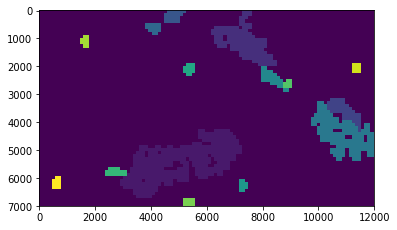

CPU times: user 16min 1s, sys: 16min 9s, total: 32min 11s
Wall time: 39min 43s


In [19]:
%%time
trial = np.zeros([m, n],dtype='float32')
mask = hsv.copy()
loc = []
for seq in range(3000):
    threshold = mask[trial==0].max()

    index_max = np.where(mask==threshold)
    xmin = index_max[1].min()
    ymin = index_max[0].min()
    xmax = index_max[1].max()
    ymax = index_max[0].max()
    
    if xmax-xmin<window_size-1 or ymax-ymin<window_size-1:
        mask[mask==threshold] = 0
        continue
    
    wx = xmin
    wy = ymin
    indices_window = np.where((locations_part[:, 0] > wx) & (locations_part[:, 0] < wx + window_size) \
                                  & (locations_part[:, 1] > wy) & (locations_part[:, 1] < wy + window_size))[0]
    cells = features_part[indices_window]
    eva = []
    foreground = []
    for i in range(20):
        x1 = background[i]
        x2, y2 = CDF(cells[:,i])
        value = stats.ks_2samp(x1, x2)[1]
        eva.append(- np.log(value))
        foreground.append(x2)
    eva = sum(sorted(eva, reverse=True)[:5])
    print(threshold, eva, len(loc))
    
    skip = 0
    for wx, wy in loc:
        distance = np.linalg.norm([wx-xmin, wy-ymin])
        if distance < 1800:
            indices_window = np.where((locations_part[:, 0] > wx) & (locations_part[:, 0] < wx + window_size) \
                                      & (locations_part[:, 1] > wy) & (locations_part[:, 1] < wy + window_size))[0]
            if len(indices_window):
                cells = features_part[indices_window]
                eva1 = []
                eva2 = []
                for i in range(20):
                    x1 = background[i]
                    x2, y2 = CDF(cells[:,i])
                    value = stats.ks_2samp(x1, x2)[1]
                    eva1.append(- np.log(value))

                    x3 = foreground[i]
                    value = stats.ks_2samp(x3, x2)[1]
                    eva2.append(- np.log(value))
                eva1 = sum(sorted(eva1, reverse=True)[:5])
                eva2 = sum(sorted(eva2, reverse=True)[:5])
                if eva1 >= alpha*eva2:
                    skip = 1
                    mask[mask==threshold] = 0
                    break
    if skip:
        continue
    loc.append([xmin, ymin])
    
    process = []
    target = [[xmin, ymin]]
    alpha = 2 + np.log10(len(loc))
    while len(target)>0:
        nodes = target
        target = []
        for tx,ty in nodes:
            xs, ys = np.meshgrid(np.arange(tx-stride, tx+2*stride, stride), np.arange(ty-stride, ty+2*stride, stride), indexing='xy')
            windows = np.c_[xs.flat, ys.flat]

            for index in range(len(windows)):
                wx = int(windows[index][0])
                wy = int(windows[index][1])
                if [wx, wy] in process:
                    continue
                process.append([wx, wy])
                indices_window = np.where((locations_part[:, 0] > wx) & (locations_part[:, 0] < wx + window_size) \
                                          & (locations_part[:, 1] > wy) & (locations_part[:, 1] < wy + window_size))[0]
                if len(indices_window):
                    cells = features_part[indices_window]
                    eva1 = []
                    eva2 = []
                    for i in range(20):
                        x1 = background[i]
                        x2, y2 = CDF(cells[:,i])
                        value = stats.ks_2samp(x1, x2)[1]
                        eva1.append(- np.log(value))

                        x3 = foreground[i]
                        value = stats.ks_2samp(x3, x2)[1]
                        eva2.append(- np.log(value))
                    eva1 = sum(sorted(eva1, reverse=True)[:5])
                    eva2 = sum(sorted(eva2, reverse=True)[:5])
                    eva = len(loc)*(eva1 >= alpha*eva2)
                    if eva!=0:
                        target.append([wx, wy])
                        for i in range(20):
                            x1, y1 = CDF(np.concatenate((foreground[i], cells[:, i])))
                            foreground[i] = x1
                        origin = trial[wy: wy + window_size, wx: wx + window_size]
                        satua_img = np.zeros_like(origin) + eva
                        comp = np.absolute(origin) - np.absolute(satua_img)
                        trial[wy: wy + window_size, wx: wx + window_size] = origin * (comp >= 0) + satua_img * (comp < 0)
#     print(len(process))
    if len(loc) == 15:
        break
plt.figure()
ks_map = trial[up:down, left:right].copy()

# com = cv2.polylines(ks_map, cs, True, [0, 255, 0], 50, lineType=8)
plt.imshow(ks_map)
plt.show()

164.63899 164.63898677427434 0
128.93054 128.9305435505852 1
106.33469 106.33468596369634 2
91.097885 91.09788214528693 3
87.005615 87.00561826861467 4
83.202255 83.20225747169111 5
77.30468 77.30467835485459 6
72.23545 72.23545019086318 7
69.85096 69.85095905560506 8
66.639694 66.6396970028869 9
66.27476 66.27475959236804 9
65.88569 65.88568847227089 10
64.86302 64.8630203195712 11
64.77943 64.7794272011793 12
64.728485 64.72848469480974 12
64.434204 64.43420343123567 12
62.560577 62.56057917902936 13
60.448948 60.44894632597848 14
60.09626 60.09625983098947 14
59.216328 59.21632611447047 14
58.030445 58.0304440779537 14
58.016323 58.0163214771303 14


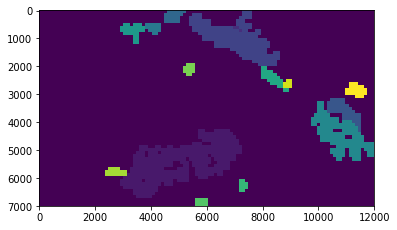

CPU times: user 9min 45s, sys: 9min 15s, total: 19min
Wall time: 34min 59s


In [13]:
%%time
stride = 112
window_size = 224
trial = np.zeros([m, n],dtype='float32')
mask = hsv.copy()
loc = []
for seq in range(3000):
    threshold = mask[trial==0].max()

    index_max = np.where(mask==threshold)
    xmin = index_max[1].min()
    ymin = index_max[0].min()
    xmax = index_max[1].max()
    ymax = index_max[0].max()
    
    if xmax-xmin<window_size-1 or ymax-ymin<window_size-1:
        mask[mask==threshold] = 0
        continue
    
    wx = xmin
    wy = ymin
    indices_window = np.where((locations_part[:, 0] > wx) & (locations_part[:, 0] < wx + window_size) \
                                  & (locations_part[:, 1] > wy) & (locations_part[:, 1] < wy + window_size))[0]
    cells = features_part[indices_window]
    eva = []
    foreground = []
    for i in range(20):
        x1 = background[i]
        x2, y2 = CDF(cells[:,i])
        value = stats.ks_2samp(x1, x2)[1]
        eva.append(- np.log(value))
        foreground.append(x2)
    eva = sum(sorted(eva, reverse=True)[:5])
    print(threshold, eva, len(loc))
    
    skip = 0
    for wx, wy in loc:
        distance = np.linalg.norm([wx-xmin, wy-ymin])
        if distance < 1000:
            indices_window = np.where((locations_part[:, 0] > wx) & (locations_part[:, 0] < wx + window_size) \
                                      & (locations_part[:, 1] > wy) & (locations_part[:, 1] < wy + window_size))[0]
            if len(indices_window):
                cells = features_part[indices_window]
                eva1 = []
                eva2 = []
                for i in range(20):
                    x1 = background[i]
                    x2, y2 = CDF(cells[:,i])
                    value = stats.ks_2samp(x1, x2)[1]
                    eva1.append(- np.log(value))

                    x3 = foreground[i]
                    value = stats.ks_2samp(x3, x2)[1]
                    eva2.append(- np.log(value))
                eva1 = sum(sorted(eva1, reverse=True)[:5])
                eva2 = sum(sorted(eva2, reverse=True)[:5])
                if eva1 >= alpha*eva2:
                    skip = 1
                    mask[mask==threshold] = 0
                    break
    if skip:
        continue
    loc.append([xmin, ymin])
    
    process = []
    target = [[xmin, ymin]]
    alpha = 2 + np.log10(len(loc))
    while len(target)>0:
        nodes = target
        target = []
        for tx,ty in nodes:
            xs, ys = np.meshgrid(np.arange(tx-stride, tx+2*stride, stride), np.arange(ty-stride, ty+2*stride, stride), indexing='xy')
            windows = np.c_[xs.flat, ys.flat]

            for index in range(len(windows)):
                wx = int(windows[index][0])
                wy = int(windows[index][1])
                if [wx, wy] in process:
                    continue
                process.append([wx, wy])
                indices_window = np.where((locations_part[:, 0] > wx) & (locations_part[:, 0] < wx + window_size) \
                                          & (locations_part[:, 1] > wy) & (locations_part[:, 1] < wy + window_size))[0]
                if len(indices_window):
                    cells = features_part[indices_window]
                    eva1 = []
                    eva2 = []
                    for i in range(20):
                        x1 = background[i]
                        x2, y2 = CDF(cells[:,i])
                        value = stats.ks_2samp(x1, x2)[1]
                        eva1.append(- np.log(value))

                        x3 = foreground[i]
                        value = stats.ks_2samp(x3, x2)[1]
                        eva2.append(- np.log(value))
                    eva1 = sum(sorted(eva1, reverse=True)[:5])
                    eva2 = sum(sorted(eva2, reverse=True)[:5])
                    eva = len(loc)*(eva1 >= alpha*eva2)
                    if eva!=0:
                        target.append([wx, wy])
                        for i in range(20):
                            x1, y1 = CDF(np.concatenate((foreground[i], cells[:, i])))
                            foreground[i] = x1
                        origin = trial[wy: wy + window_size, wx: wx + window_size]
                        satua_img = np.zeros_like(origin) + eva
                        comp = np.absolute(origin) - np.absolute(satua_img)
                        trial[wy: wy + window_size, wx: wx + window_size] = origin * (comp >= 0) + satua_img * (comp < 0)
#     print(len(process))
    if len(loc) == 15:
        break
plt.figure()
ks_map = trial[up:down, left:right].copy()

# com = cv2.polylines(ks_map, cs, True, [0, 255, 0], 50, lineType=8)
plt.imshow(ks_map)
plt.show()

In [12]:
loc

[[44608, 23040],
 [44832, 18784],
 [43824, 18448],
 [49200, 21920],
 [42816, 18112],
 [42032, 18560],
 [48304, 22032],
 [41024, 18560],
 [46512, 20576],
 [45168, 24160],
 [43712, 24832],
 [43264, 20016],
 [40576, 23600],
 [46848, 20576],
 [49424, 20800]]

In [13]:
loc

[[44608, 23040],
 [44832, 18784],
 [43824, 18448],
 [49200, 21920],
 [42816, 18112],
 [42032, 18560],
 [48304, 22032],
 [41024, 18560],
 [46512, 20576],
 [45168, 24160],
 [43712, 24832],
 [43264, 20016],
 [40576, 23600],
 [46848, 20576],
 [49424, 20800],
 [39568, 19008],
 [49312, 20016],
 [48192, 20912],
 [38448, 24048],
 [44720, 20240],
 [38000, 19120],
 [44720, 20016],
 [49088, 23488],
 [46512, 19456],
 [42816, 19568],
 [40912, 19904],
 [39120, 22928],
 [43040, 22368],
 [39680, 24272],
 [42256, 24496],
 [42480, 19568],
 [44832, 24272],
 [47520, 20128],
 [45952, 22928],
 [39344, 18000],
 [42144, 21024],
 [38112, 18224],
 [45280, 23040],
 [39568, 24496],
 [43264, 24384],
 [42256, 19232],
 [48640, 20016],
 [38672, 18000],
 [43600, 24048],
 [43600, 19568],
 [45168, 22592],
 [45840, 18112],
 [43824, 24272],
 [45056, 23488],
 [46064, 18448],
 [38112, 22480],
 [43600, 20016],
 [49536, 20240],
 [42704, 20352],
 [44160, 23936],
 [49424, 20464],
 [38672, 20128],
 [47072, 24608],
 [39456, 24272

In [14]:
loc

[[44608, 23040],
 [44832, 18784],
 [42480, 23264],
 [43824, 18448],
 [43488, 23040],
 [41360, 23936],
 [49200, 21920],
 [42816, 18112],
 [42032, 18560],
 [48304, 22032],
 [41024, 18560],
 [46512, 20576],
 [45168, 24160],
 [43712, 24832],
 [43264, 20016],
 [46848, 20576],
 [40016, 24160],
 [49424, 20800],
 [39568, 19008],
 [49312, 20016],
 [48640, 23040],
 [48192, 20912],
 [38448, 24048],
 [44720, 20240],
 [38000, 19120],
 [44720, 20016],
 [46512, 19456],
 [40912, 19904],
 [40800, 22816],
 [39120, 22928],
 [42256, 24496],
 [42480, 19568],
 [47520, 20128],
 [45952, 22928],
 [49424, 24160],
 [39344, 18000],
 [42144, 21024],
 [45280, 23040],
 [39568, 24496],
 [43264, 24384],
 [48640, 20016],
 [38672, 18000],
 [43600, 24048],
 [43600, 19568],
 [45840, 18112],
 [43824, 24272],
 [45056, 23488],
 [46064, 18448],
 [38112, 22480],
 [49536, 20240],
 [42704, 20352],
 [44160, 23936],
 [49424, 20464],
 [38672, 20128],
 [47072, 24608],
 [40688, 21472],
 [48080, 19344],
 [46400, 20016],
 [49872, 22928

In [14]:
loc

[[44608, 23040],
 [44832, 18784],
 [42480, 23264],
 [43824, 18448],
 [43488, 23040],
 [41360, 23936],
 [49200, 21920],
 [42816, 18112],
 [42032, 18560],
 [48304, 22032],
 [41024, 18560],
 [46512, 20576],
 [45168, 24160],
 [43712, 24832],
 [43264, 20016],
 [46848, 20576],
 [40016, 24160],
 [49424, 20800],
 [39568, 19008],
 [49312, 20016],
 [48640, 23040],
 [48192, 20912],
 [38448, 24048],
 [44720, 20240],
 [38000, 19120],
 [44720, 20016],
 [46512, 19456],
 [40912, 19904],
 [40800, 22816],
 [39120, 22928]]

In [13]:
savepath = "/Users/kuiqian/Desktop/Features/KS/"
np.save(savepath+'trial_5C_15_DK39_adaptive.npy', trial[up:down, left:right])